# Trentino Data: Initial Impressions and Exploration

I will try to elaborate on my thought process as i went through this exercise. My first half hour was spent just looking at the data and the accompanying API documentation files provided. 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [2]:
data_paths = {
         "trentino_grid": r"input\1_Trentino_Grid\trentino-grid.geojson",
         "internet": r"input\2_Telecommunications_Internet\Internet_traffic_activity.csv",
         "precipitation": r"input\3_Precipitation_-_Trentino\precipitation-trentino-201312.csv",
         "precipitation_availability": r"input\3_Precipitation_-_Trentino\precipitation-trentino-data-availability-201312.csv",
         "electricity_line": r"input\4_SET_Electricity\line.csv",
         "electricity_dec": r"input\4_SET_Electricity\SET-dec-2013.csv",
         "air_quality": r"input\5_Air_Quality_TN\air-2013-12.csv"
         }

At this stage, I still only had a vague idea about the data, so it was important to start somewhere. The very first file provided was a GeoJson file, which i was not familiar with. So i decided to get it up and running first, and see if that could lead me somewhere. I spent a couple hours going through some online tutorials, found out about and geopandas and got it up and running.

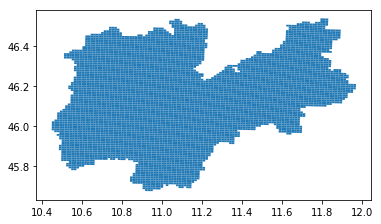

In [3]:
df_trentino = gpd.read_file(data_paths["trentino_grid"])
df_trentino.set_index('cellId', inplace=True)
ax = df_trentino.plot()

Ah, so that's how Trentino looks! But this alone does not provide any additional insights. Time to get some data in. I decided to start with the internet data next.

In [4]:
df_internet = pd.read_csv(data_paths["internet"],
                          header=None,
                          names=['Square_id',
                                 'Timestamp',
                                 'Internet_traffic_activity'
                                 ]
                          )

df_internet.head()

,Square_id,Timestamp,Internet_traffic_activity
0,10000,2013-12-01 00:00,9.381368
1,10000,2013-12-01 01:00,11.966050
2,10000,2013-12-01 02:00,10.588980
3,10000,2013-12-01 03:00,8.662089
4,10000,2013-12-01 04:00,7.491499


In [5]:
print(len(df_internet))
print("This value should be 31 days if the dataset is properly prepared ",
      len(df_internet[df_internet['Square_id'] == 38]) / 24)

9292838
This value should be 31 days if the dataset is properly prepared  62.0


At this point, i noticed that there was an issue with this dataset. Essentially, there was data duplication in the source file for some reason. I have just picked one sample Square_id 38 to demonstrate the issue.

In [6]:
df_internet.drop_duplicates(inplace=True)
print(len(df_internet))
print("This value should be 31 days if the dataset is properly prepared ",
      len(df_internet[df_internet['Square_id'] == 38]) / 24)

4646419
This value should be 31 days if the dataset is properly prepared  31.0


In [7]:
#convert to datetime, useful later
df_internet['Timestamp'] = pd.to_datetime(df_internet['Timestamp'])

Text(0, 0.5, 'Average Internet Traffic Activity')

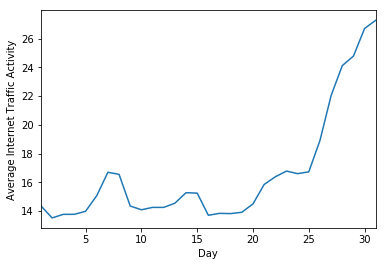

In [8]:
#Day aggregated plot
df_internet['day'] = df_internet['Timestamp'].dt.day

day_wise_internet_use = df_internet.groupby('day')['Internet_traffic_activity'].mean()

f = plt.figure()
ax = day_wise_internet_use.plot()
plt.xlabel("Day")
plt.ylabel("Average Internet Traffic Activity")

It is interesting to see how the internet activity changes at the end of the month. This may be due to Christmas and New Year related activities.

Text(0, 0.5, 'Average Internet Traffic Activity')

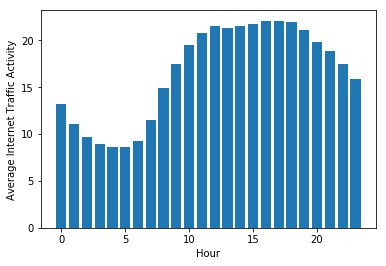

In [9]:
#Hour aggregated plot
df_internet['hour'] = df_internet['Timestamp'].dt.hour
hour_wise_internet_use = df_internet.groupby('hour')['Internet_traffic_activity'].mean()
f = plt.bar(hour_wise_internet_use.index, hour_wise_internet_use)
plt.xlabel("Hour")
plt.ylabel("Average Internet Traffic Activity")

Nothing unexpected here, 3-6am is the quietest time in terms of internet traffic, while the usage remains fairly high throughout the office hours until 6pm or so.

In [10]:
#Now, merge with geopandas dataframe to utilize the geopandas plotting capabilities.
out = df_internet.groupby("Square_id").agg({'Internet_traffic_activity': 'mean'})
df_geo_internet = pd.merge(df_trentino,
                             out,
                             how='inner',
                             left_index=True,
                             right_index=True
                             )
df_geo_internet.describe()

,Internet_traffic_activity
count,6259.000000
mean,16.597104
std,38.068554
min,0.000475
25%,4.015669
50%,9.223922
75%,18.069153
max,1317.762919


 At this point, i decided to go with a simple mean on the entire dataset for the month of December, just to get comfortable with geopandas plotting.
Initially, i tried to use a more traditional "gradient scaled" heatmap, but the max value is very high in comparison to the median values, making the map look essentially empty. After some digging online trying to get the scales to behave, I found an alternative using quantile bins and decided to go with them for now.

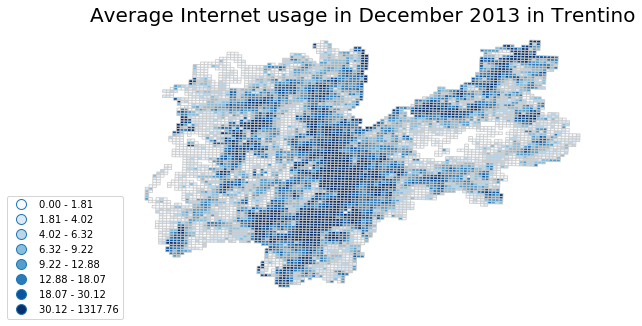

In [11]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Internet_traffic_activity'

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(9, 5))
ax.axis('off')
ax.set_title('Average Internet usage in December 2013 in Trentino',
             fontdict={'fontsize': '20',
                       'fontweight' : '3'
                       }
             )
df_geo_internet.plot(column=variable,
                     cmap='Blues',
                     linewidth=0.8,
                     ax=ax,
                     edgecolor='0.8',
                     k=8,
                     scheme='Quantiles',
                     legend=True
                     )

ax.get_legend().set_bbox_to_anchor((.01, .4))

At this moment, looking at the internet usage pattern on the map, a couple ideas started forming in my head. 
I decided to pick one that could potentially be promising and very useful if it proved successful. The hypothesis was whether internet patterns could be used to predict peak power consumptions for the day. As electricity is wasteful to store, companies have to estimate electricity consumption rates and generate electricity according to the demand. Knowing peak consumption rates could prove useful in saving costs and resources.

With that in mind, I needed to load and use the electricity data.

In [12]:
df_electricity_line = pd.read_csv(data_paths["electricity_line"])
df_electricity_usage = pd.read_csv(data_paths["electricity_dec"],
                                   header=None)
df_electricity_usage['date'] = pd.to_datetime(df_electricity_usage[1])
df_electricity_usage.describe()

,2
count,821376.000000
mean,36.128447
std,31.330017
min,-300.959991
25%,14.725000
50%,29.950001
75%,50.750000
max,296.100006


At this point, i was very concerned with the negative minimum value, but fortunately the API docs clarify it further. According to docs: "it happens because of the solar panel and power lines electricity production"

In [13]:
print("total number of rows in line dataset ",len(df_electricity_line))
#Expected all squareid to be unique, but there are repetitions.
print("number of unique square ids ", df_electricity_line['SQUAREID'].nunique())
df_electricity_line.drop_duplicates() #did nothing

df_electricity_line[df_electricity_line['SQUAREID'] == 860] #sample demonstration

total number of rows in line dataset  2575
number of unique square ids  2020


,SQUAREID,LINESET,NR_UBICAZIONI
26,860,DG1003117,2
27,860,DG1031221,174


The result above was also a cause for concern.
It makes sense that a square grid may be powered by more than one power supply Line. 
But this may hamper the data-joins further down the line. 
At this point I decided to revisit this later if i had time.

In [14]:
idx = pd.date_range('12-01-2013', '12-31-2013 23:00:00', freq='H')
def interpolate_for_missing_time(df):
    if len(df) == len(idx):
        return df['Internet_traffic_activity']
    temp = df['Internet_traffic_activity']
    temp.index = pd.DatetimeIndex(df['Timestamp'])
    temp = temp.reindex(idx, fill_value=np.nan)
    temp = temp.interpolate()
    return temp 
print("before treatment of missing values ", len(df_internet))
out = df_internet.groupby('Square_id').apply(interpolate_for_missing_time).reset_index()
print("after treatment", len(out))
out.head()

before treatment of missing values  4646419
after treatment 4656696


,Square_id,level_1,Internet_traffic_activity
0,38,38185,13.931525
1,38,38186,10.326146
2,38,38187,8.148137
3,38,38188,7.032447
4,38,38189,7.437181


This section above was where i realised that the internet dataset had missing timestamps! I decided to interpolate the internet traffic activity levels at the missing time stamps, as that seems like a reasonable approach to deal with the missing data at this step.

In [15]:
#prepare dataset to join. added a 3 hour aggregation on the data for ease of analysis.
X = out['Internet_traffic_activity'].values.reshape(-1, 31, 8, 3)
X = X.mean(axis=-1)
square_ids = out['Square_id'].unique()
days = np.arange(1, 32)
time_chunks = np.arange(1, 9)
to_join = pd.DataFrame(itertools.product(square_ids, days),
                    columns=['Square_id', 'day'])
temp = pd.DataFrame(X.reshape(-1, len(time_chunks)), columns=time_chunks)
to_join = pd.concat([to_join, temp], axis=1)
to_join.head()

,Square_id,day,1,2,3,4,5,6,7,8
0,38,1,10.801936,7.062447,11.924742,25.701668,19.000863,27.790413,38.369406,30.094492
1,38,2,11.171418,7.538939,13.973119,19.144319,17.875953,16.249012,16.959212,19.048920
2,38,3,11.084854,9.120474,17.056583,17.735127,19.588634,16.988634,25.708634,14.914357
3,38,4,8.493525,7.904177,15.319960,17.717824,20.687080,21.332506,18.042172,14.236411
4,38,5,9.079546,8.193315,17.995960,15.186269,22.477238,20.013145,19.947927,16.813095


A quick-n-dirty approach to dealing with temporal data without having to deal with them. I decided to do an aggregation on 3 hour chunks, and essentially "transpose" the data chunks for each day for every square. This allows the use of traditional regression models for initial assessment while still conveying some semblance of time in the data itself. This dataframe is ready to be further joined now.

In [16]:
electricity_by_square = pd.merge(df_electricity_line,
                                 to_join, 
                                 how='inner',
                                 left_on='SQUAREID', 
                                 right_on='Square_id'
                                 )
print(len(electricity_by_square))
electricity_by_square.head()

78523


,SQUAREID,LINESET,NR_UBICAZIONI,Square_id,day,1,2,3,4,5,6,7,8
0,155,DG1031221,4,155,1,13.523748,9.475867,20.692771,39.064376,30.601954,41.536064,58.532627,35.341744
1,155,DG1031221,4,155,2,14.105767,10.404019,19.081635,25.590789,24.447534,27.717674,27.290676,26.485260
2,155,DG1031221,4,155,3,16.859970,12.444853,21.272013,25.114837,24.531293,24.562081,29.633451,19.062967
3,155,DG1031221,4,155,4,11.706150,10.589562,21.543605,32.824159,26.454842,30.282029,23.217247,17.202968
4,155,DG1031221,4,155,5,9.655011,10.357232,20.685471,23.317415,29.581549,30.746865,33.176127,28.055537


At this point, things are coming together. we finally have the "LINESET" context needed for each power supply line. At this point, another major decision had to be taken on how to aggregate the data. I had initially opted for a mean at this step, but later changed this to a sum. However, this step is where one would need to explore further and decide on a good metric for aggregation. 

In [17]:
agg_func = {k: 'sum' for k in time_chunks}
agg_func.update({'SQUAREID': 'count',
                 'NR_UBICAZIONI': 'sum',
                 }
                )
final_df = electricity_by_square.groupby(['LINESET', 'day']).agg(agg_func)
final_df.head()

1         2          3          4          5  \
LINESET   day                                                         
DG1000011 1     9.079587  7.916396   9.947056  13.623328  14.590148   
          2     8.375053  7.646101  12.193573  13.664291  16.298849   
          3    10.727853  8.499838  11.770575  15.824837  16.661709   
          4    10.971587  9.345441  12.140351  14.511964  15.542446   
          5    11.338151  9.289111  13.806536  15.478022  20.136173   

                       6          7          8  SQUAREID  NR_UBICAZIONI  
LINESET   day                                                            
DG1000011 1    16.737611  14.588101  12.220161         1              6  
          2    15.743250  17.654172  15.494427         1              6  
          3    19.945711  17.490946  15.641237         1              6  
          4    16.915736  18.338859  13.845860         1              6  
          5    18.581729  18.373451  14.910175         1              6

In [18]:
target = df_electricity_usage.copy()
target['day'] = target['date'].dt.day
target.rename(columns={0:'LINESET',
                       2: 'Amperes'},
                inplace=True)



out = target.groupby(['LINESET', 'day']).agg({'Amperes': 'max'})

df = out.merge(final_df, left_index=True, right_index=True)
print(len(df))
df.head()

5704


Amperes           1           2           3           4  \
LINESET   day                                                              
DG1000420 1    54.899998  427.529080  285.550615  301.584539  569.141780   
          2    98.819992  274.404490  246.840898  378.910835  368.536262   
          3    96.839996  310.659545  272.704120  397.337076  382.075450   
          4    95.579994  288.145466  236.860172  381.717777  416.925495   
          5    94.859993  300.831691  278.890604  422.485042  381.500653   

                        5           6           7           8  SQUAREID  \
LINESET   day                                                             
DG1000420 1    627.262650  605.735477  573.790046  429.027033        21   
          2    424.067112  423.083494  563.759971  487.885631        21   
          3    365.450960  437.014931  481.804754  440.493742        21   
          4    401.273713  441.774931  480.563738  422.117364        21   
          5    430.376117  420.094868  493.096239  458.954681        21   

               NR_UBICAZIONI  
LINESET   day                 
DG1000420 1             2133  
          2             2133  
          3             2133  
          4             2133  
          5             2133

The dataset is now prepared and ready to be used. With this kind of aggregation, there are only 5704 rows left. In hindsight, the level of aggregation here might be too aggressive, and we may have lost of lot of information going by a day-level aggregation. Let's see what the initial models say. 

In [19]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [20]:
X = df[time_chunks]
Y = df['Amperes']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=42
                                                    )

scaler = preprocessing.StandardScaler().fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

I did not spend a lot of time preprocessing at this stage, just decided to use a simple scaler. We have already lost a lot of information by the aggregations earlier, and at this stage, we need to see the initial assessment for a baseline.

In [21]:
lr = linear_model.LinearRegression()
lr.fit(X_tr_scaled, y_train)
y_pred_tr = lr.predict(X_tr_scaled)
y_pred = lr.predict(X_test_scaled)


print('Coefficients: \n', lr.coef_)
# The mean squared error
print("Mean squared error Train: {:.2f}".format(mean_squared_error(y_train, y_pred_tr)))
print("Mean squared error Test: {:.2f}".format(mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ -2.18601411  10.40208      5.69596332  36.06783012 -55.79569432
  18.93325218 -44.89355649  45.31210917]
Mean squared error Train: 1412.64
Mean squared error Test: 1477.91
Variance score: 0.12


In [22]:
tree_regr = DecisionTreeRegressor(random_state=42)

tree_regr.fit(X_tr_scaled, y_train)
y_pred_tr = tree_regr.predict(X_tr_scaled)
y_pred = tree_regr.predict(X_test_scaled)

print('Feature Importances: \n', tree_regr.feature_importances_)
# The mean squared error
print("Mean squared error Train: {:.2f}".format(mean_squared_error(y_train, y_pred_tr)))
print("Mean squared error Test: {:.2f}".format(mean_squared_error(y_test, y_pred)))

Feature Importances: 
 [0.11418089 0.1108361  0.1071653  0.24185912 0.10364525 0.07670231
 0.11060971 0.13500132]
Mean squared error Train: 11.02
Mean squared error Test: 2103.11


Oh dear! The initial assessment looks rough, but there are a lot of things that deserve further exploration here before concluding one way or another.

A wrap up of the thoughts i had during the exercise:
1. In hindsight, it seems as if the level of aggregation may need to be further explored and tweaked before we can conclusively decide whether internet activity can help indicate electricity consumption or not.

2. The "NR_UBICAZIONI" column may be very important and require treatment, essentially something i considered but did not explore further was if the internet_usage values should have been divided by the NR_UBICAZIONI values. It may be a key missing link in the current assessment.

3. The "1 grid 2 power supplies" issue was essentially ignored in the initial assessment above. It is important to further analyse whether that had a significant negative impact on the model evaluations. 

4. There may be some preprocessing needed, especially when it comes to handling how the internet usage patterns have spikes very far from the mean values, which may cause issues for the models.

Some other ideas that also seem worth exploring:

1. There may be a link between the precipitation and air quality levels, It is something we always assume and observe in cities here. It would be interesting to explore if the same holds true in Italy as well, or will the results surprise us.

2. Does internet usage have a correlation with air quality levels? It seems like at a glance, the two are unrelated, but it is also possible that internet usage and air quality both may share a common driver, essentially population density. It may be worth exploring how accurate that hunch really is.

3. Can these metrics be used to cluster city grids on similarities and perhaps enable us to derive useful information that way? It seems natural that some bifurcation of city grids in terms of type of residency may enable us to better predict peak energy consumption for example.

4. There's always room for more of those geopandas plots! I wish i had time to pursue them further, they seem very useful at conveying information at a glance.